In [14]:
import pandas as pd
import numpy as np
import datetime

df = pd.read_csv("../../data/clean/bitcoin_prices.csv")
df = df.iloc[::24, :]

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)
start_date = datetime.datetime(2015,7,1)
df = df[df["Time"] > start_date]

print(df.columns)

Index(['Unnamed: 0', 'Time', 'Low', 'High', 'Open', 'Close', 'Volume'], dtype='object')


In [19]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import sys
import datetime
import backtrader as bt
import backtrader.analyzers as btanalyzers

class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

### Buy and HODL
class BaselineStrategy(bt.Strategy):
    
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            cash = self.broker.get_cash()
            limit_price = self.data.close[0] * 1.01
            size = (cash * 0.95) / limit_price
            print(cash, self.data.close[0], limit_price, size)
            self.buy(exectype=bt.Order.Limit, size=size)

cerebro = bt.Cerebro()

from_date=datetime.datetime(2016, 1, 1)
to_date = datetime.datetime(2020, 12, 30)

# Create data feeds
data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)

cerebro.broker.setcash(10000.0)
cerebro.broker.addcommissioninfo(CommInfoFractional())
cerebro.broker.setcommission(commission=0.005, margin=False, mult=1.0, commtype=None, percabs=True, stocklike=False, interest=0.0, interest_long=False, leverage=1.0, automargin=False, name=None)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annualreturn')
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='tradeanalyzer')

cerebro.addobserver(bt.observers.DrawDown)

# Add the strategy
cerebro.addstrategy(BaselineStrategy)

# Run the strategy
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

strats = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2015-07-20, Close, 278.00
10000.0 278.0 280.78000000000003 33.83431868366692
2015-07-21, Close, 279.86
10000.0 279.86 282.65860000000004 33.609449703635406
2015-07-22, BUY EXECUTED, 277.46
2015-07-22, Order Canceled/Margin/Rejected
2015-07-22, Close, 277.10
2015-07-23, Close, 276.70
2015-07-24, Close, 289.29
2015-07-25, Close, 288.49
2015-07-26, Close, 293.88
2015-07-27, Close, 296.66
2015-07-28, Close, 296.00
2015-07-29, Close, 291.55
2015-07-30, Close, 287.94
2015-07-31, Close, 285.02
2015-08-01, Close, 281.20
2015-08-02, Close, 282.28
2015-08-03, Close, 282.53
2015-08-04, Close, 286.10
2015-08-05, Close, 283.37
2015-08-06, Close, 279.20
2015-08-07, Close, 279.77
2015-08-08, Close, 266.66
2015-08-09, Close, 266.91
2015-08-10, Close, 264.99
2015-08-11, Close, 269.70
2015-08-12, Close, 270.03
2015-08-13, Close, 265.10
2015-08-14, Close, 267.52
2015-08-15, Close, 264.05
2015-08-16, Close, 259.99
2015-08-17, Close, 258.46
2015-08-18, Close, 251.99
2015-

2018-02-09, Close, 8553.00
2018-02-10, Close, 8287.90
2018-02-11, Close, 8315.01
2018-02-12, Close, 8819.10
2018-02-13, Close, 8568.01
2018-02-14, Close, 9296.10
2018-02-15, Close, 9860.80
2018-02-16, Close, 10083.01
2018-02-17, Close, 10850.81
2018-02-18, Close, 10770.01
2018-02-19, Close, 11077.61
2018-02-20, Close, 11711.77
2018-02-21, Close, 10282.60
2018-02-22, Close, 9915.00
2018-02-23, Close, 9920.00
2018-02-24, Close, 9505.33
2018-02-25, Close, 9591.15
2018-02-26, Close, 10375.17
2018-02-27, Close, 10740.00
2018-02-28, Close, 10531.00
2018-03-01, Close, 10917.99
2018-03-02, Close, 11026.00
2018-03-03, Close, 11298.98
2018-03-04, Close, 11390.00
2018-03-05, Close, 11555.98
2018-03-06, Close, 10789.90
2018-03-07, Close, 9960.02
2018-03-08, Close, 9337.01
2018-03-09, Close, 9004.83
2018-03-10, Close, 8829.29
2018-03-11, Close, 9536.01
2018-03-12, Close, 9100.01
2018-03-13, Close, 9099.59
2018-03-14, Close, 8039.00
2018-03-15, Close, 8300.00
2018-03-16, Close, 8509.94
2018-03-17, C

2019-07-16, Close, 9654.39
2019-07-17, Close, 9813.63
2019-07-18, Close, 10608.84
2019-07-19, Close, 10569.22
2019-07-20, Close, 10967.67
2019-07-21, Close, 10571.92
2019-07-22, Close, 10269.88
2019-07-23, Close, 10121.86
2019-07-24, Close, 9780.00
2019-07-25, Close, 9893.67
2019-07-26, Close, 9836.00
2019-07-27, Close, 9504.37
2019-07-28, Close, 9445.95
2019-07-29, Close, 9496.13
2019-07-30, Close, 9586.21
2019-07-31, Close, 10041.84
2019-08-01, Close, 10423.40
2019-08-02, Close, 10421.63
2019-08-03, Close, 10847.68
2019-08-04, Close, 10974.69
2019-08-05, Close, 11746.36
2019-08-06, Close, 11356.13
2019-08-07, Close, 11929.13
2019-08-08, Close, 11714.90
2019-08-09, Close, 11909.89
2019-08-10, Close, 11299.80
2019-08-11, Close, 11499.85
2019-08-12, Close, 11390.01
2019-08-13, Close, 10855.01
2019-08-14, Close, 10186.69
2019-08-15, Close, 10339.90
2019-08-16, Close, 10445.49
2019-08-17, Close, 10139.95
2019-08-18, Close, 10422.14
2019-08-19, Close, 10713.03
2019-08-20, Close, 10790.54
2

OrderedDict([('rtot', 4.492468564979681),
             ('ravg', 0.0022597930407342462),
             ('rnorm', 0.7673263118491326),
             ('rnorm100', 76.73263118491326)])
Returns: None
OrderedDict([('sharperatio', 0.6297829137519342)])
Sharpe Ratio: None
OrderedDict([(2015, 0.5211591459505664),
             (2016, 1.1918398789317246),
             (2017, 13.291935596436272),
             (2018, -0.7381833026223341),
             (2019, 0.9457495050721862),
             (2020, 2.680404145404089)])
Annual Return: None
AutoOrderedDict([('len', 1),
                 ('drawdown', 1.131872694341344),
                 ('moneydown', 10228.114538072608),
                 ('max',
                  AutoOrderedDict([('len', 1082),
                                   ('drawdown', 83.69642909656326),
                                   ('moneydown', 551260.862597051)]))])
Drawdown: None
AutoOrderedDict([('total', AutoOrderedDict([('total', 1), ('open', 1)]))])
Trade Analyzer: None


<IPython.core.display.Javascript object>


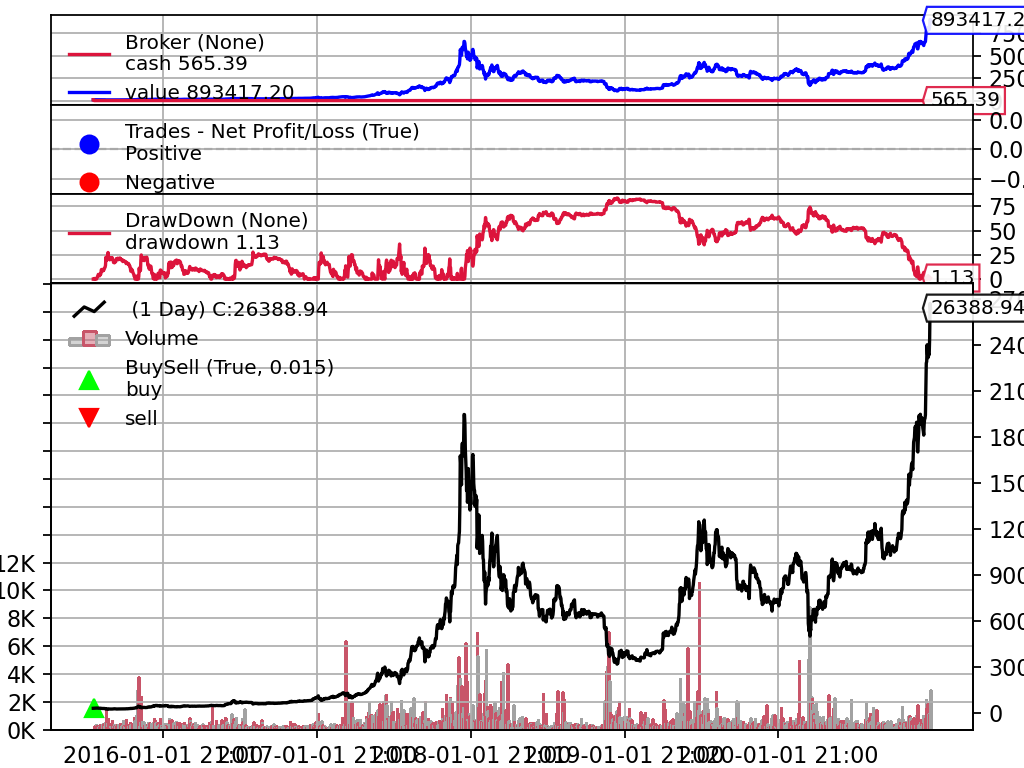

[[<Figure size 640x480 with 5 Axes>]]

In [20]:
print('Returns:', strats[0].analyzers.returns.pprint())
print('Sharpe Ratio:', strats[0].analyzers.mysharpe.pprint())
print('Annual Return:', strats[0].analyzers.annualreturn.pprint())
print('Drawdown:', strats[0].analyzers.drawdown.pprint())
print('Trade Analyzer:', strats[0].analyzers.tradeanalyzer.pprint())
cerebro.plot()